In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


# Loading Datasets

In [ ]:
btc_data = pd.read_csv("/content/drive/MyDrive/4180/research project /bitcoin_2017_to_2023.csv")

In [ ]:
btc_data.shape

(3126000, 10)

In [ ]:
btc_tweets_data = pd.read_csv("/content/drive/MyDrive/4180/research project /Bitcoin_tweets.csv",skiprows=range(1, 100000),nrows=900000)

<ipython-input-3-6bf40a9dc970>:1: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  btc_tweets_data = pd.read_csv("/content/drive/MyDrive/4180/research project /Bitcoin_tweets.csv",skiprows=range(1, 100000),nrows=900000)


In [ ]:
btc_tweets_data.shape

(900000, 13)

# Data Preprocessing

BTC Data

In [ ]:
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])

# Filtering data for to match the btc_tweets selection
start_date = '2021-04-17'
end_date = '2021-08-21'
mask = (btc_data['timestamp'] >= start_date) & (btc_data['timestamp'] <= end_date)
btc_data = btc_data.loc[mask].reset_index(drop=True)

# filter out unnecessary rows
btc_keep_rows =["timestamp","close","number_of_trades"]
btc_data = btc_data[btc_keep_rows]

#check for null
btc_data.isnull().sum()

,0
timestamp,0
close,0
number_of_trades,0


Text(0.5, 1.0, 'Bitcoin Close Price Over Time')

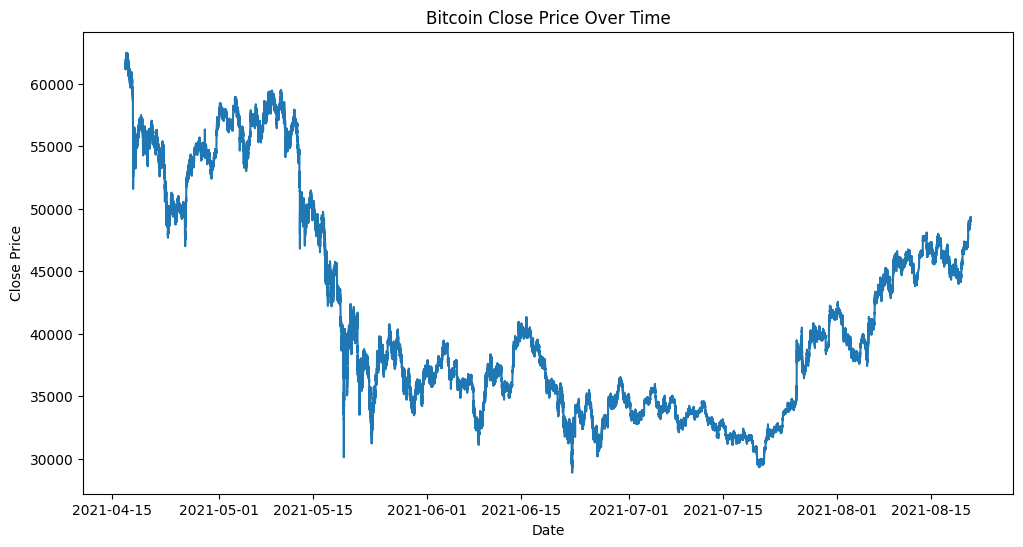

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(btc_data['timestamp'], btc_data['close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Price Over Time')

BTC Tweets

In [ ]:
# converting date to datetime data type
btc_tweets_data['date'] = pd.to_datetime(btc_tweets_data['date'], errors='coerce')

# drop unnecessary columns
tweet_keep_columns = ['user_name', 'user_followers', 'date', 'text', 'user_verified']
btc_tweets_data = btc_tweets_data[tweet_keep_columns]

# check for null values
btc_tweets_data.isnull().sum()

,0
user_name,18
user_followers,0
date,4
text,0
user_verified,0


In [ ]:
#drop null date
btc_tweets_data = btc_tweets_data.dropna(subset=['date'])

# verify
btc_tweets_data.isnull().sum()

,0
user_name,18
user_followers,0
date,0
text,0
user_verified,0


# User distribution

In [ ]:
# create new col is_influencer where user_followers> 1000 and user_verified == True
btc_tweets_data['is_influencer'] = (btc_tweets_data['user_followers'] > 1000) & (btc_tweets_data['user_verified'] == True)

In [ ]:
print(btc_tweets_data['user_name'].nunique())

179274


Text(0, 0.5, '')

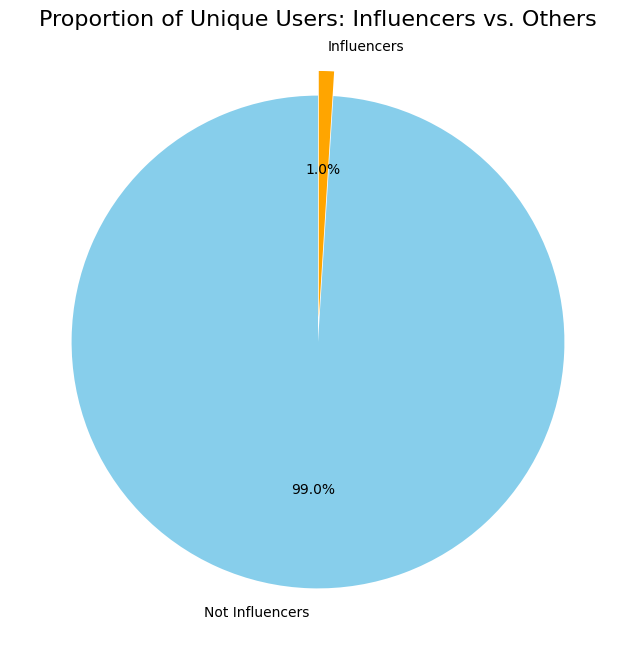

In [ ]:
unique_users_by_group = btc_tweets_data.groupby('is_influencer')['user_name'].nunique()

plt.figure(figsize=(8, 8))

unique_users_by_group.plot(
    kind='pie',
    labels=['Not Influencers', 'Influencers'],
    autopct='%1.1f%%',
    colors=['skyblue', 'orange'],
    startangle=90,
    explode=(0, 0.1),
)

plt.title('Proportion of Unique Users: Influencers vs. Others', fontsize=16)
plt.ylabel('')

# Tweet Text Cleaning

In [ ]:
def clean_text(text):
    text = str(text)
    text = text.replace('\n', ' ')
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

In [ ]:
# create a clean_text column using custom function
btc_tweets_data['clean_text'] = btc_tweets_data['text'].apply(clean_text)

#check null on clean_text
btc_tweets_data[['clean_text']].isnull().sum()

,0
clean_text,0


# Sentiment Analysis using Vader on clean_text

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    return analyzer.polarity_scores(text)['compound']

# create new column sentiment_score
btc_tweets_data['sentiment_score'] = btc_tweets_data['clean_text'].apply(get_sentiment_score)

In [ ]:
# reindex to date
btc_tweets_data.set_index('date', inplace=True)

# resample sentiment score
# ffill
daily_sentiment_mean = btc_tweets_data['sentiment_score'].resample('D').mean().ffill()

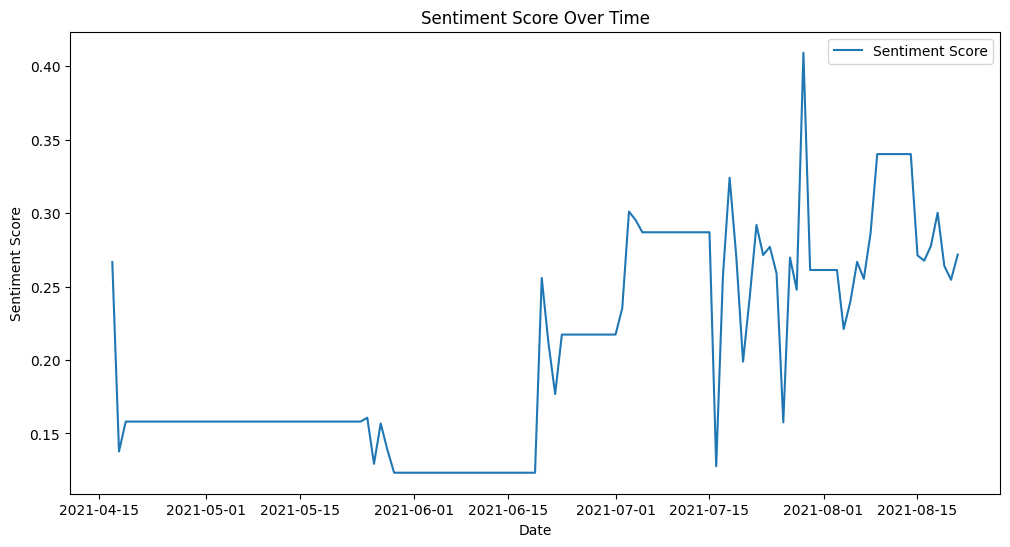

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment_mean.index, daily_sentiment_mean, label='Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score Over Time')
plt.legend()

# Sentiment of verified influencers

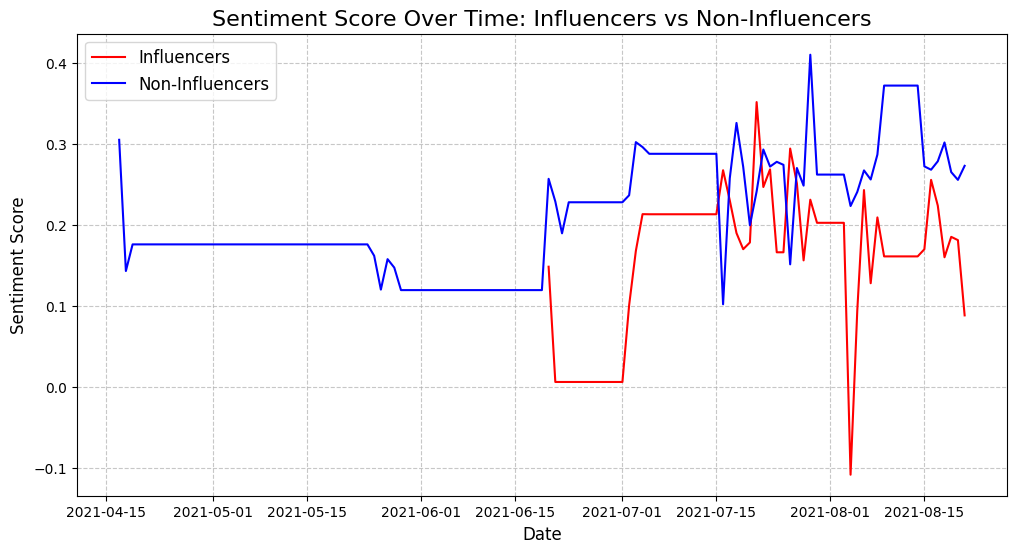

In [ ]:
influencers = btc_tweets_data[(btc_tweets_data['user_followers'] > 1000) & (btc_tweets_data['user_verified'] == True)]
non_influencers = btc_tweets_data[((btc_tweets_data['user_followers'] < 1000) | (btc_tweets_data['user_verified'] == False))]

# Resample daily mean sentiment scores
influencers_daily_mean = influencers['sentiment_score'].resample('D').mean().ffill()
non_influencers_daily_mean = non_influencers['sentiment_score'].resample('D').mean().ffill()


plt.figure(figsize=(12, 6))
plt.plot(influencers_daily_mean.index, influencers_daily_mean, label='Influencers', color='red', linestyle='-')
plt.plot(non_influencers_daily_mean.index, non_influencers_daily_mean, label='Non-Influencers', color='blue', linestyle='-')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.title('Sentiment Score Over Time: Influencers vs Non-Influencers', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Sentiment Compared to Actual BTC Close Price

In [ ]:
btc_data.set_index('timestamp', inplace=True)

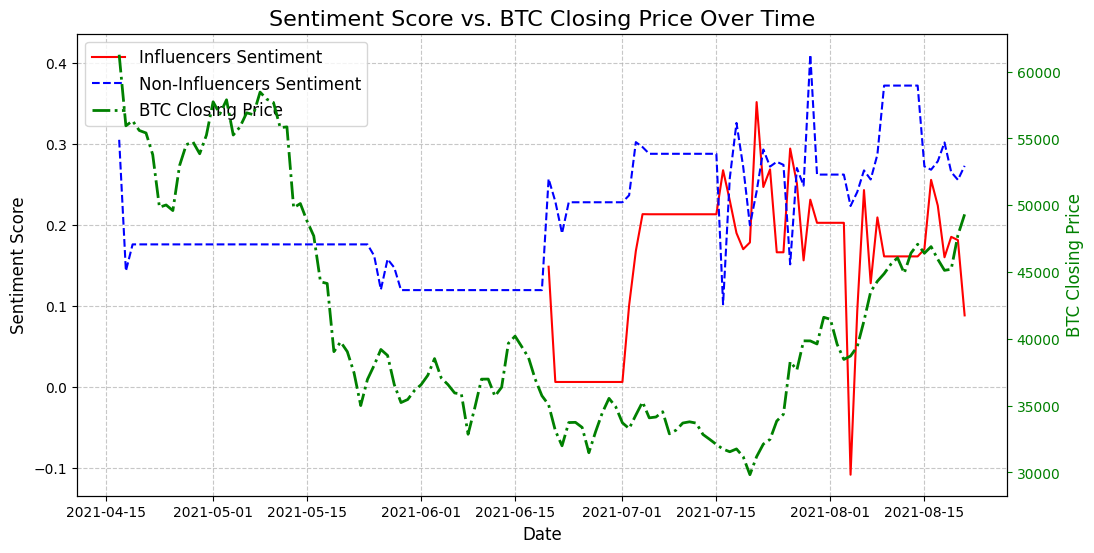

In [ ]:
btc_daily_close = btc_data['close'].resample('D').mean()

plt.figure(figsize=(12, 6))

plt.plot(influencers_daily_mean.index, influencers_daily_mean, label='Influencers Sentiment', color='red', linestyle='-')
plt.plot(non_influencers_daily_mean.index, non_influencers_daily_mean, label='Non-Influencers Sentiment', color='blue', linestyle='--')

# secondary y-axis for BTC closing price
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(btc_daily_close.index, btc_daily_close, label='BTC Closing Price', color='green', linestyle='-.', linewidth=2)
ax2.set_ylabel('BTC Closing Price', fontsize=12, color='green')
ax2.tick_params(axis='y', colors='green')


ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Sentiment Score', fontsize=12)
ax1.set_title('Sentiment Score vs. BTC Closing Price Over Time', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)


lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)

Text(0.5, 1.0, 'Correlation Heatmap')

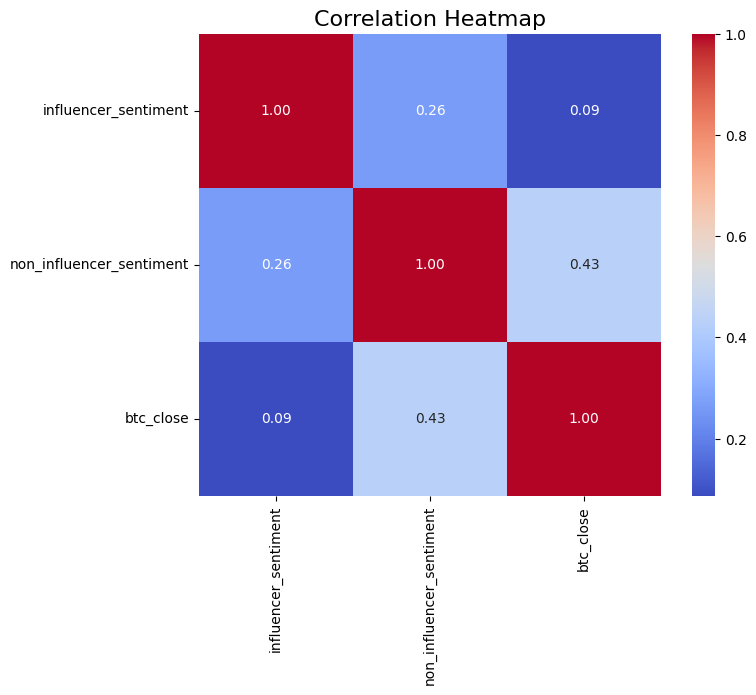

In [ ]:
combined_data = pd.DataFrame({
    'influencer_sentiment': influencers_daily_mean,
    'non_influencer_sentiment': non_influencers_daily_mean,
    'btc_close': btc_daily_close
}).dropna()

correlation_matrix = combined_data.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar=True,
    square=True
)

plt.title('Correlation Heatmap', fontsize=16)


In [ ]:
combined_data.columns

Index(['influencer_sentiment', 'non_influencer_sentiment', 'btc_close'], dtype='object')

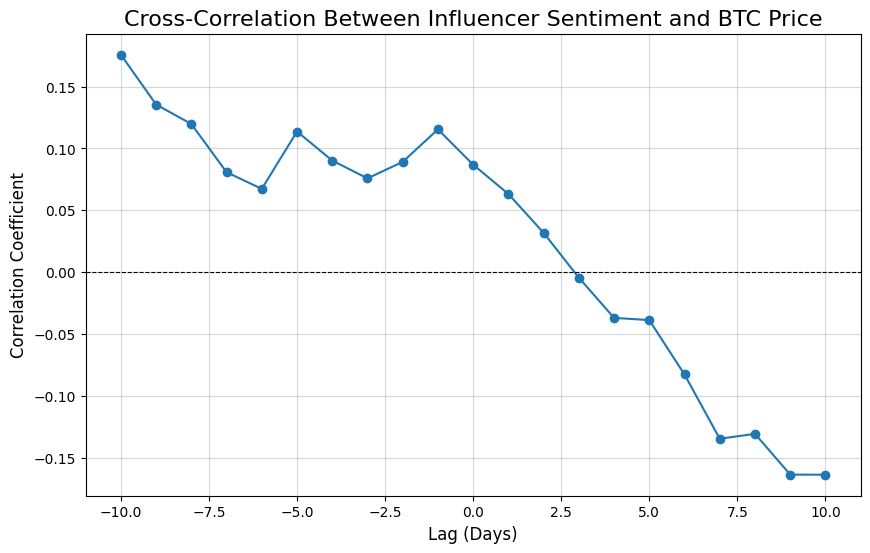

In [ ]:
# Cross-correlation between influencer sentiment and BTC price
influencer_sentiment = combined_data['influencer_sentiment']
btc_price = combined_data['btc_close']

lags = range(-10, 11)  =
cross_corr = [influencer_sentiment.corr(btc_price.shift(lag)) for lag in lags]


plt.figure(figsize=(10, 6))
plt.plot(lags, cross_corr, marker='o', linestyle='-')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Cross-Correlation Between Influencer Sentiment and BTC Price', fontsize=16)
plt.xlabel('Lag (Days)', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.grid(alpha=0.5)

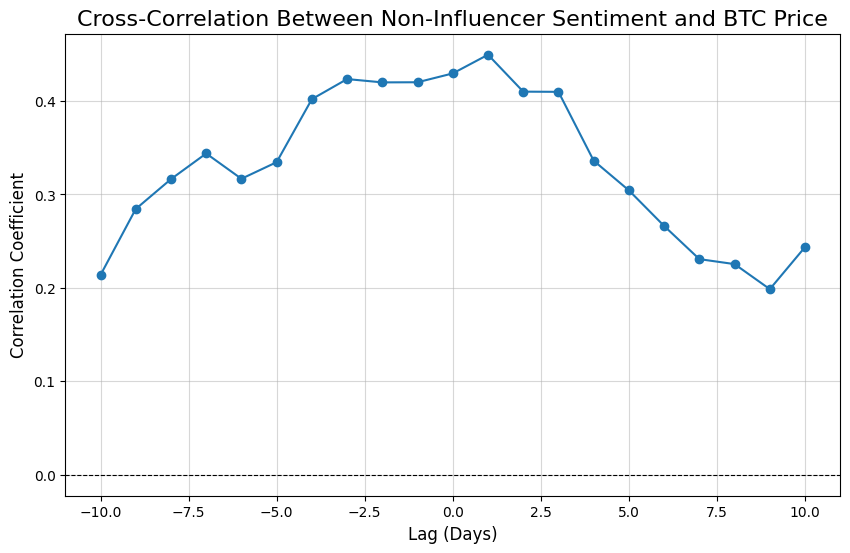

In [ ]:
# Cross-correlation between non-influencer sentiment and BTC price
non_influencer_sentiment = combined_data['non_influencer_sentiment']
btc_price = combined_data['btc_close']

lags = range(-10, 11)
cross_corr = [non_influencer_sentiment.corr(btc_price.shift(lag)) for lag in lags]


plt.figure(figsize=(10, 6))
plt.plot(lags, cross_corr, marker='o', linestyle='-')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Cross-Correlation Between Non-Influencer Sentiment and BTC Price', fontsize=16)
plt.xlabel('Lag (Days)', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.grid(alpha=0.5)